In [130]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.distributions import Normal

import math
import time

from utils import *
from plot_utils import *
#from utils import plot_s
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [131]:
# model and flow parameters
hidden_dim = 32
width= 64
t0 = 0  # flow start time
t1 = 1  # flow end time

# optimization parameters
lr= 3e-3

In [132]:
# model
cnf= CNF(in_out_dim=2, hidden_dim=hidden_dim, width=width).to(device)
print(cnf)
ts= torch.tensor([t1, t0]).type(torch.float32).to(device)# for training, we flow the samples backward (in time)


CNF(
  (net): HyperNetwork(
    (fc1): Linear(in_features=1, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=448, bias=True)
  )
)


In [134]:
def prior():
    return Normal(
        loc=torch.zeros(2),
        scale=torch.ones(2),
    )
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[0.1, 0.0], [0.0, 0.1]]).to(device)
)

In [135]:
_csv='/Users/ssa195/Downloads/dt8122-2022-main/datasets/boomerang.csv'
_data=Dataset2D(csv_file=_csv)
train_dataloader, test_dataloader = get_train_test_loader(_csv)
num_batches = train_dataloader.__len__()
#plot_samples(train_dataloader)

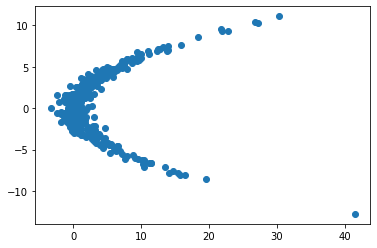

In [136]:
#plot training data
tr=None
for x,y,data in train_dataloader:
    #print(x.shape)
    if tr is not None:
        tr=torch.cat((tr,data),dim=0)
    else:
        tr=data.clone()
    

plt.scatter(tr[:,0],tr[:,1] )

In [141]:
start= time.time()

#Training
optimizer = torch.optim.Adam(cnf.parameters(), lr=lr)

epochs = 1000  # 300

print('Training...')
cnf = cnf.train()
a = 0
z0 = []

for epoch in range(1, epochs):
    loss_sum = 0.0
    for i, (x,y,data) in enumerate(train_dataloader):
        data = data.type(torch.FloatTensor).to(device)
        x1 = data
        optimizer.zero_grad()
        a += x1.size()[0]
        # initialize initial densities
        logp_diff_t1 = torch.zeros(x1.size()[0], 1).type(torch.float32).to(device)

        # compute the backward solutions
        z_t, logp_diff_t = cnf(ts, x1, logp_diff_t1)  # outputs time first
        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
        z0.append(z_t0.detach().cpu())

        # compute the density of each sample
        logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0  # .view(-1)
        loss = -logp_x.mean(0)
        loss.sum().backward()
        optimizer.step()
        loss_sum += loss.sum().detach().cpu().item()

    if epoch % 1 == 0:
        print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch, epochs, loss_sum / len(train_dataloader)))
    
    if epoch % 5 == 0:
        torch.save(cnf, '/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_boomerang/model.pt')
        
cnf = cnf.eval()

end = time.time()
print('Training finished in: ', (end - start) / 60, 'minutes')


Training...
Epoch: 1/1000, Loss: 198.463
Epoch: 2/1000, Loss: 191.530
Epoch: 3/1000, Loss: 187.679
Epoch: 4/1000, Loss: 184.759
Epoch: 5/1000, Loss: 183.303
Epoch: 6/1000, Loss: 178.839
Epoch: 7/1000, Loss: 177.167
Epoch: 8/1000, Loss: 174.648
Epoch: 9/1000, Loss: 171.683
Epoch: 10/1000, Loss: 169.326
Epoch: 11/1000, Loss: 168.719
Epoch: 12/1000, Loss: 164.816
Epoch: 13/1000, Loss: 162.630
Epoch: 14/1000, Loss: 160.813
Epoch: 15/1000, Loss: 159.415
Epoch: 16/1000, Loss: 157.539
Epoch: 17/1000, Loss: 155.625
Epoch: 18/1000, Loss: 154.032
Epoch: 19/1000, Loss: 152.571
Epoch: 20/1000, Loss: 151.383
Epoch: 21/1000, Loss: 150.424
Epoch: 22/1000, Loss: 148.883
Epoch: 23/1000, Loss: 148.104
Epoch: 24/1000, Loss: 146.982
Epoch: 25/1000, Loss: 145.410
Epoch: 26/1000, Loss: 143.922
Epoch: 27/1000, Loss: 142.654
Epoch: 28/1000, Loss: 141.819
Epoch: 29/1000, Loss: 141.055
Epoch: 30/1000, Loss: 141.143
Epoch: 31/1000, Loss: 140.394
Epoch: 32/1000, Loss: 139.434
Epoch: 33/1000, Loss: 138.476
Epoch: 

Epoch: 269/1000, Loss: 131.175
Epoch: 270/1000, Loss: 131.595
Epoch: 271/1000, Loss: 130.876
Epoch: 272/1000, Loss: 130.776
Epoch: 273/1000, Loss: 130.935
Epoch: 274/1000, Loss: 131.422
Epoch: 275/1000, Loss: 131.683
Epoch: 276/1000, Loss: 131.076
Epoch: 277/1000, Loss: 131.324
Epoch: 278/1000, Loss: 131.080
Epoch: 279/1000, Loss: 131.029
Epoch: 280/1000, Loss: 130.644
Epoch: 281/1000, Loss: 130.943
Epoch: 282/1000, Loss: 131.384
Epoch: 283/1000, Loss: 131.169
Epoch: 284/1000, Loss: 130.917
Epoch: 285/1000, Loss: 130.808
Epoch: 286/1000, Loss: 130.865
Epoch: 287/1000, Loss: 130.972
Epoch: 288/1000, Loss: 130.895
Epoch: 289/1000, Loss: 131.269
Epoch: 290/1000, Loss: 131.859
Epoch: 291/1000, Loss: 131.312
Epoch: 292/1000, Loss: 131.122
Epoch: 293/1000, Loss: 130.772
Epoch: 294/1000, Loss: 131.345
Epoch: 295/1000, Loss: 131.181
Epoch: 296/1000, Loss: 131.191
Epoch: 297/1000, Loss: 131.822
Epoch: 298/1000, Loss: 130.794
Epoch: 299/1000, Loss: 131.543
Epoch: 300/1000, Loss: 131.009
Epoch: 3

Epoch: 534/1000, Loss: 130.164
Epoch: 535/1000, Loss: 131.105
Epoch: 536/1000, Loss: 130.895
Epoch: 537/1000, Loss: 130.541
Epoch: 538/1000, Loss: 130.119
Epoch: 539/1000, Loss: 130.590
Epoch: 540/1000, Loss: 130.242
Epoch: 541/1000, Loss: 130.629
Epoch: 542/1000, Loss: 130.288
Epoch: 543/1000, Loss: 129.758
Epoch: 544/1000, Loss: 129.877
Epoch: 545/1000, Loss: 129.885
Epoch: 546/1000, Loss: 130.354
Epoch: 547/1000, Loss: 130.054
Epoch: 548/1000, Loss: 130.173
Epoch: 549/1000, Loss: 130.728
Epoch: 550/1000, Loss: 130.181
Epoch: 551/1000, Loss: 130.354
Epoch: 552/1000, Loss: 129.763
Epoch: 553/1000, Loss: 130.069
Epoch: 554/1000, Loss: 130.239
Epoch: 555/1000, Loss: 130.388
Epoch: 556/1000, Loss: 130.058
Epoch: 557/1000, Loss: 130.294
Epoch: 558/1000, Loss: 130.459
Epoch: 559/1000, Loss: 130.388
Epoch: 560/1000, Loss: 130.164
Epoch: 561/1000, Loss: 129.973
Epoch: 562/1000, Loss: 130.417
Epoch: 563/1000, Loss: 130.151
Epoch: 564/1000, Loss: 130.509
Epoch: 565/1000, Loss: 130.069
Epoch: 5

Epoch: 799/1000, Loss: 127.428
Epoch: 800/1000, Loss: 126.985
Epoch: 801/1000, Loss: 127.274
Epoch: 802/1000, Loss: 127.097
Epoch: 803/1000, Loss: 127.647
Epoch: 804/1000, Loss: 127.208
Epoch: 805/1000, Loss: 127.483
Epoch: 806/1000, Loss: 127.349
Epoch: 807/1000, Loss: 128.070
Epoch: 808/1000, Loss: 127.027
Epoch: 809/1000, Loss: 126.970
Epoch: 810/1000, Loss: 127.178
Epoch: 811/1000, Loss: 127.056
Epoch: 812/1000, Loss: 127.091
Epoch: 813/1000, Loss: 126.979
Epoch: 814/1000, Loss: 126.774
Epoch: 815/1000, Loss: 127.827
Epoch: 816/1000, Loss: 127.275
Epoch: 817/1000, Loss: 127.533
Epoch: 818/1000, Loss: 127.424
Epoch: 819/1000, Loss: 127.197
Epoch: 820/1000, Loss: 128.118
Epoch: 821/1000, Loss: 127.128
Epoch: 822/1000, Loss: 127.371
Epoch: 823/1000, Loss: 126.921
Epoch: 824/1000, Loss: 126.683
Epoch: 825/1000, Loss: 126.654
Epoch: 826/1000, Loss: 127.511
Epoch: 827/1000, Loss: 127.247
Epoch: 828/1000, Loss: 128.131
Epoch: 829/1000, Loss: 126.701
Epoch: 830/1000, Loss: 126.985
Epoch: 8

In [142]:
torch.save(cnf, '/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_boomerang/model.pt')

In [143]:
trained_cnf=torch.load('/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_boomerang/model.pt')
trained_cnf = trained_cnf.eval()

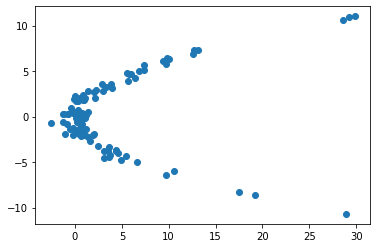

In [144]:
d=None
for x,y,data in test_dataloader:
    #print(x.shape)
    if d is not None:
        d=torch.cat((d,data),dim=0)
    else:
        d=data.clone()
    

plt.scatter(d[:,0],d[:,1] )

In [152]:
def plot_cnf_animation(target_sample, t0, t1, viz_timesteps, p_z0, z_t1, z_t_samples, z_t_density, logp_diff_t,img_path):
    

    for (t, z_sample, z_density, logp_diff) in zip(
            np.linspace(t0, t1, viz_timesteps),
            z_t_samples, z_t_density, logp_diff_t):
        fig = plt.figure(figsize=(12, 4), dpi=200)
        plt.tight_layout()
        plt.axis('off')
        plt.margins(0, 0)
        fig.suptitle(f'{t:.2f}s')

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_title('Target')
        ax1.get_xaxis().set_ticks([])
        ax1.get_yaxis().set_ticks([])
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title('Samples')
        ax2.get_xaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title('Log Probability')
        ax3.get_xaxis().set_ticks([])
        ax3.get_yaxis().set_ticks([])

        ax1.hist2d(*target_sample.detach().cpu().numpy().T, bins=200, density=True,
                   range=[[-4, 4], [-4, 4]])
        #ax1.scatter(*target_sample.detach().cpu().numpy().T)
        ax2.hist2d(*z_sample.detach().cpu().numpy().T, bins=200, density=True,
                   range=[[-4, 4], [-4, 4]])
        #ax2.scatter(*z_sample.detach().cpu().numpy().T)
        logp = p_z0.log_prob(z_density) - logp_diff.view(-1)
        ax3.tricontourf(*z_t1.detach().cpu().numpy().T,
                        np.exp(logp.detach().cpu().numpy()), 200)

        plt.savefig(os.path.join(img_path, f"cnf-viz-{int(t*1000):05d}.jpg"),
                   pad_inches=0.2, bbox_inches='tight')
        plt.close()

    imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(img_path, f"cnf-viz-*.jpg")))]

    fig = plt.figure(figsize=(18,6))
    ax  = fig.gca()
    img = ax.imshow(imgs[0])

    def animate(i):
        img.set_data(imgs[i])
        return img,

    anim = animation.FuncAnimation(fig, animate, frames=41, interval=200)
    plt.close()
    return anim

In [153]:
#!pip install ipython
from IPython import display
# samples
viz_samples   = d.shape[0]
viz_timesteps = 41

t0 = 0  # flow start time
t1 = 1  # flow end time

# simulate the flow
with torch.no_grad():
    # Generate evolution of samples
    z_t0 = p_z0.sample([viz_samples]).to(device)
    logp_diff_t0 = torch.zeros(viz_samples, 1).type(torch.float32).to(device)

    ts = torch.tensor(np.linspace(t0, t1, viz_timesteps)).to(device)
    z_t_samples, _  = trained_cnf(ts, z_t0, logp_diff_t0)

    # Generate evolution of density
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    points = np.vstack(np.meshgrid(x, y)).reshape([2, -1]).T
    
    z_t1 = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(z_t1.shape[0], 1).type(torch.float32).to(device)
    ts = torch.tensor(np.linspace(t1, t0, viz_timesteps)).to(device)
    z_t_density, logp_diff_t = trained_cnf(ts, z_t1, logp_diff_t1)
    
img_path = os.path.join('/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_boomerang/')
anim = plot_cnf_animation(d, t0, t1, viz_timesteps, p_z0, z_t1, z_t_samples, z_t_density, logp_diff_t,img_path)
display.HTML(anim.to_jshtml())

In [147]:
#function to create and save gif from saved images
def make_gif(frame_folder,gif_name):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.jpg"))]
    print(len(frames))
    frame_one = frames[0]
    frame_one.save(gif_name, append_images=frames,
               save_all=True, duration=100, loop=0)

In [148]:
#create and save gif from saved cnf images
make_gif("/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_boomerang",'/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_boomerang/cnf_boomerang.gif')

41


torch.Size([10000, 2])


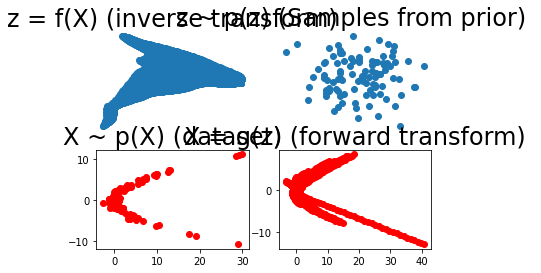

In [149]:
print(z_t_density[-1,:,:].size())
# create final 4 fig subplot
plot_final(test_dataloader,z_t0,z_t_samples,z_t_density[-1,:,:])